In [2]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score

## Load data

In [3]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
# y_test = np.load("y_test.npy")

In [4]:
# 7000 data with 300 features
print(x_train.shape)

(7000, 300)


In [5]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function.<br />
Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. <br />
Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. <br />
The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [6]:
def cross_validation(x_train, y_train, k=5):
    # get an array of shuffled index
    shuffle_index = np.random.choice(len(x_train), len(x_train), replace=False)
    kfold_data = []
    r, n = len(x_train) % k, len(x_train) // k

    i = 0
    while i < len(x_train):
        # to handle the case that the sample size is not divisible by k
        if r > 0: # first r folds have size (n + 1)
            train = np.concatenate((shuffle_index[:i], shuffle_index[i+n+1:]), axis=0)
            val = shuffle_index[i:i+n+1]
            kfold_data.append([train, val])
            i += n + 1
            r -= 1
        else:
            train = np.concatenate((shuffle_index[:i], shuffle_index[i+n:]), axis=0)
            val = shuffle_index[i:i+n]
            kfold_data.append([train, val])
            i += n

    return kfold_data

In [7]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 700 # The number of data in each validation fold should equal to training data divieded by K

## example

In [8]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kfold_data = []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    kfold_data.append([train_index, val_index])

Split: 1, Training index: [ 1  3  4  5  7  8 10 11 12 13 14 15 16 17 18 19], Validation index: [0 2 6 9]
Split: 2, Training index: [ 0  2  3  4  5  6  8  9 10 11 12 13 14 15 17 18], Validation index: [ 1  7 16 19]
Split: 3, Training index: [ 0  1  2  3  5  6  7  8  9 11 12 14 16 17 18 19], Validation index: [ 4 10 13 15]
Split: 4, Training index: [ 0  1  2  3  4  6  7  9 10 11 13 14 15 16 18 19], Validation index: [ 5  8 12 17]
Split: 5, Training index: [ 0  1  2  4  5  6  7  8  9 10 12 13 15 16 17 19], Validation index: [ 3 11 14 18]


In [9]:
assert len(kfold_data) == 5 # should contain 5 fold of data
assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [10]:
clf = SVC(C=1.0, kernel='rbf', gamma=0.01)

In [11]:
# generate training and validation set index via cross validation
kfold_data = cross_validation(x_train, y_train, k=5)

# different C and gamma values to perform grid search
C = [10000, 1000, 100, 10, 1, 0.5, 0.3, 0.1]
gamma = [0.00005, 0.0001, 0.00015, 0.0002, 0.00025, 0.0003, 0.00035, 0.0004, 0.00045, 0.0005]
# save the accuracy scores in result to plot heatmap in Question 3
result = []

best_score = 0
for c in C:
    tmp = []
    for g in gamma:
        # initialize the classifier
        clf = SVC(C=c, kernel='rbf', gamma=g)
        score = 0
        for i in range(len(kfold_data)):
            # get the training and validation data
            X, Y = [x_train[x] for x in kfold_data[i][0]], [y_train[y] for y in kfold_data[i][0]]
            x_val, y_val = [x_train[x] for x in kfold_data[i][1]], [y_train[y] for y in kfold_data[i][1]]
            # train the model
            clf.fit(X, Y)
            # add up the scores of each split
            score += accuracy_score(y_val, clf.predict(x_val))
        # calculate the average score of the parameters    
        score /= len(kfold_data)
        tmp.append(round(score, 3))
        print("C:", c, "\tG:", g, "\t\t", score)  
        if score > best_score: 
            best_score, best_parameters = score, (c, g)
    result.append(tmp)

print(result)    

C: 10000 	G: 5e-05 		 0.9925714285714285
C: 10000 	G: 0.0001 		 0.9932857142857141
C: 10000 	G: 0.00015 		 0.9931428571428571
C: 10000 	G: 0.0002 		 0.9927142857142857
C: 10000 	G: 0.00025 		 0.9917142857142857
C: 10000 	G: 0.0003 		 0.9911428571428571
C: 10000 	G: 0.00035 		 0.9907142857142859
C: 10000 	G: 0.0004 		 0.9912857142857143
C: 10000 	G: 0.00045 		 0.9782857142857143
C: 10000 	G: 0.0005 		 0.859
C: 1000 	G: 5e-05 		 0.9925714285714285
C: 1000 	G: 0.0001 		 0.9932857142857141
C: 1000 	G: 0.00015 		 0.9931428571428571
C: 1000 	G: 0.0002 		 0.9927142857142857
C: 1000 	G: 0.00025 		 0.9917142857142857
C: 1000 	G: 0.0003 		 0.9911428571428571
C: 1000 	G: 0.00035 		 0.9907142857142859
C: 1000 	G: 0.0004 		 0.9912857142857143
C: 1000 	G: 0.00045 		 0.9782857142857143
C: 1000 	G: 0.0005 		 0.859
C: 100 	G: 5e-05 		 0.9925714285714285
C: 100 	G: 0.0001 		 0.9932857142857141
C: 100 	G: 0.00015 		 0.9931428571428571
C: 100 	G: 0.0002 		 0.9927142857142857
C: 100 	G: 0.00025 		 0.991714

In [12]:
# (C, gamma)
print(best_parameters)

(1, 0.0001)


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. <br/>
And the color represents the average score of validation folds<br/>
You reults should be look like this reference image below <br/><br/>
 ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

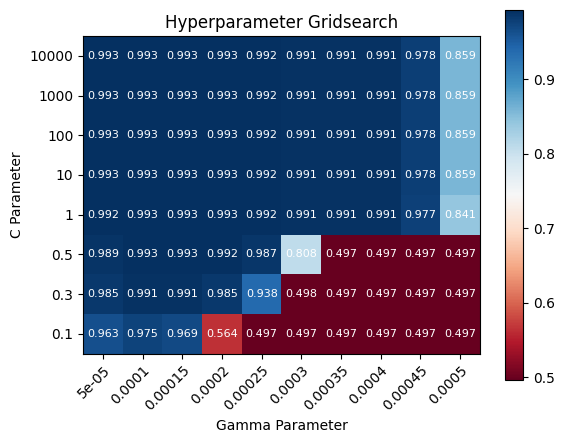

In [24]:
import matplotlib.pyplot as plt

result = np.array(result)
fig, ax = plt.subplots()
im = ax.imshow(result, cmap="RdBu")

# Title and X, Y label
ax.set_title("Hyperparameter Gridsearch")
plt.xlabel("Gamma Parameter")
plt.ylabel("C Parameter")
ax.set_xticks(np.arange(len(gamma)), labels=gamma)
ax.set_yticks(np.arange(len(C)), labels=C)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Generate text annotations
for i in range(len(C)):
    for j in range(len(gamma)):
        text = ax.text(j, i, result[i, j], ha="center", va="center", color="w", fontsize=8)
        
# Color bar
plt.colorbar(im)
plt.show()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [14]:
best_model = SVC(C=1.0, kernel='rbf', gamma=0.0001)
best_model.fit(x_train, y_train)

SVC(gamma=0.0001)

In [15]:
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

NameError: name 'y_test' is not defined